---
OSE Scentific Computation Final Project in WS 2020/2021| Msc. Economics Bonn University| Author: Po-Tse Cheng

# Generalised Stochastic Simulation Algorithm: Python Implementation and Benchmarking

### Original Paper: Numerically stable and accurate stochastic simulation approaches for solving dynamic economic models

#### Original Author: Kenneth L. Judd, Lilia Maliar, Serguei Maliar

##### Published Journal:  Quantitative Economics, 2011

---

In [1]:
# import custom functions
from tools.auxiliary import*
from tools.GSSA_1_agent import*
from tools.GSSA_countries import*
# This is to hide some run-time error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# todo 
# recomment the comments
# proofread
# conclusion sucks
# make sure the number of equation is correct
# add hyper link for references

### General Information regarding this Notebook:

- The original matlab code can be accessed [here](https://web.stanford.edu/~maliars/Files/GSSA_Two_Models.zip).

- The paper can be accessed [here](https://onlinelibrary.wiley.com/doi/pdf/10.3982/QE14).

*What can be expected:*

1. All matlab codes from the original authors have been translated into python, including Appendix.

2. Besides of the representitive agent model, a multicountry model purposed by the paper is also implemented in python.

3. Instead of presenting the results in merely tables, I construct figures as they are more intuitive.

4. All the functions used in the python code share the exact same name as the original code to enhance transparency, please validate this by looking at the code.

5. The functions are all well-documented.

6. Time consuming calculations have been cached.

*What is the caveats:*

1. Two proximation methods included in GSSA, namely LAD-DP and RLAD-DP are not implemented.

2. This notebook does not aim to replicate everything in the paper, rather to showcase important properties for GSSA.

3. There are unfortunately around 2000 to 3000 lines of codes.

### Table of Content
---
**1. [Introduction](#chap1)**  <a id='top'></a>  
    
**2. [Background](#chap2)**
    
$\quad$ **2.1** [The Representitive Agent Model](#chap2.1)

$\quad$ **2.2** [Why Stochastic Simulation Models?](#chap2.2)

$\quad$ **2.3** [Problems with Stochastic Methods](#chap2.3)

$\quad$ **2.4** [From PEA to GSSA](#chap2.4)

**3. [Mechanisms of GSSA](#chap3)**

$\quad$ **3.1** [GSSA Stage 1](#chap3.1)

$\quad$ **3.2** [GSSA Stage 2](#chap3.2)

$\quad$ **3.3** [GSSA Results Showcase](#chap3.3)

**4. [Stability and Accuracy Enhancement](#chap4)**

$\quad$ **4.1** [Ill-conditioned LS problems](#chap4.1)

$\quad$ **4.2** [Stability Enhancement](#chap4.2)

$\qquad$ **4.2.1** [Polynomial Families](#chap4.2.1)

$\qquad$ **4.2.2** [LS Approaches](#chap4.2.2)

$\qquad$ **4.2.3** [LAD Approaches](#chap4.2.3)

$\quad$ **4.3** [Accuracy Enhancement](#chap4.2)

**5. [Countries Implementation](#chap5)**

**6. [Conclusion](#chap6)**

[References](#ref)

# 1. Introduction <a id='chap1'></a>
---

When it comes to solving dynamic stochastic economics model, there are three mainstream methods: (1) projection methods, (2) perturbation methods, and (3) stochastic simulation methods. Projection methods are accurate and fast, as the solutions lie in a pre-defined grid. Christiano et al. (2000) for example use projection method to take advantage of the increase accuracy and speed. However, projection methods are not suitable for dealing with high dimensional models, as the cost grows exponetionally with the state variables. Perturbation methods have the exact opposite characteristics: They are well-equiped for high dimension problems, but are in general slow and less accurate. Simulation methods on the other hand are easy to construct. However, simulation methods in most case are plagued by low accuracy and numerical instability in higher polynomials. General Stochastic Simulation Algorithm (GSSA) aims to combine the advantages from all three methods. The reasoning behind choosing simulation method as the core of the algorithm, is because simulation methods are easily expandable in codes. Moreover, simulation methods are fast as they only consider solutions within the domain constructed by simulations (iterations).

-----

This notebook is constructed as follows: We will first talk about some background information for running a simulation stochastic model. In section 3, we will be looking at the mechanisms of the GSSA. We will then move on to see how GSSA address the problem plaguing the conventional simulation methods. We will also implement a multicountry model to further show the achievement of GSSA. We will conclude the notebook with more potential usage for GSSA in the economics field.

# 2. Background <a id='chap2'></a>
---

In this section, we will first set up a classical representitive agent model as our target problem. Furthermore, we will discuss the advantages and disadvantages of simulation models. Finally, we will show the mechanisms of PEA algorithm developed by Marcet (1988) and the improvements GSSA made from the predecessor.

## 2.1 The Representitive Agent Model <a id='chap2.1'></a>
---

Consider an agent that faces intertemporal utility-maximisation problem:

\begin{align*}



\max_{\{k_{t+1}, c_{t}\}_{t=0,...,\infty}}&E_{0}\sum^{\infty}_{t=0}\beta^{t}u(c_{t}) \tag{1} \\
s.t.\quad &c_{t}+k_{t+1}=(1-\delta)k_{t}+a_{t}f(k_{t}), \tag{2}\\
&\ln a_{t+1}=\rho\ln a_{t}+\epsilon_{t+1}, \epsilon_{t+1}\sim \mathcal{N}(0,\,\sigma^{2}) \tag{3}\\
&u^{'}(c_{t})=E_{t}\{\beta u^{'}(c_{t+1}) [1-\delta+a_{t+1}f^{'}(k_{t+1})]\} \tag{4}


\end{align*}

  Where $u(\boldsymbol{\cdot})$ represents the utility function, $E_{t}$ on the other hand denotes the expectation operator for the information given at time $t$.  $c_{t}$, $k_{t}$, $a_{t}$ stands for consumption, capital, and productivity level respectively. $f(\boldsymbol{\cdot})$ describes the production function. $\beta \in (0,1)$ denotes the discount factor; while $\delta \in (0,1]$ and $\rho \in (-1,1)$ represents depreciation of capital and autocorrelation coefficient of the productivity level. $\sigma \geq 0$ stands for the standard deviation of the productivity shock. Notice that during $t=0$ both $k_{0}$ and $a_{0}$ are given. The solution to the stochastic model needs to satisfy the Euler equation (4), while also both transition equations (2) (3). Our objective will be trying to obtain both policy and consumption function, which denotes as $K(\boldsymbol{\cdot})$, $C(\boldsymbol{\cdot})$. Both solutions also need to be able to represent as a Markov equilibrium such that $k_{t+1}= K(k_{t},a_{t})$ and $c_{t}=C(k_{t}, a_{t})$.

## 2.2 Why Stochastic Simulation Models? <a id='chap2.2'></a>
---

The biggest advantage of using stochastic simulation method is it only considers solutions that are part of the state space visited in equilibrium. In other words, solutions can only be from the space created by simulations, which translates into a higher probability to be the right answers. Taking the closed-form solutions from the representitive agent model, we can see that in Figure (1) the ovel shape from the solutions does not occupy the whole rectangular space. To be even more precise, the solutions take around 79% of the space or 21% smaller than the original space.

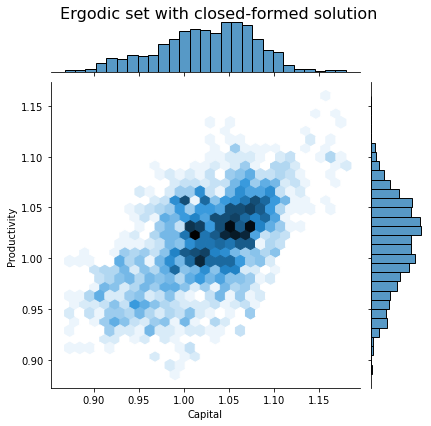

In [3]:
Figure1()

This occupying ratio quickly decreases as the dimension increases. Consider $\nu^{d}$ denotes the ratio of a $d$-dimensional hypersphere to $d$-dimensional hypercube with both diameter set to 1. The general form of the ratio can be express as follow:

\begin{align*}
\nu^{d}=
\begin{cases}
      \frac{(\pi/2)^{(d-1)/2}}{1\cdot3\cdot,...,d} & \text{for $d=1,3,5,...$}\\
      \frac{(\pi/2)^{d/2}}{2\cdot4\cdot,...,d} & \text{for $d=2,4,6,...$}\\
\end{cases}     
\end{align*}

We can observe that the ratio $\nu^{d}$ decrease rapidly with the increase of dimension. Stochastic simulation methods therefore have the advantage of not calculating the whole sets of potential candidates, which translate into lower computational cost. The larger the dimension, the larger the cost save. Another great perk is that given the model only consider relevant domain, via fitting the polynomials one is able to achieve great accuracy than conventional projection methods. Maliar et al.(2010) further provide evidence to the latter claim.

## 2.3 Problems with Stochastic Methods <a id='chap2.3'></a>
---

Despite the promising theoretical perspectives, most conventional simulation models have disappointing results in real practices. Not only are they not able to obtain high accuracy as projection methods, it is also difficult for them to reach numerical stability in higher polynomials. Let us consider a generic stochastic algorithm for model solving:
<ol>
 <li>Guessing the policy or value function</li>
 <li>Simulate the time series solution</li>
 <li>Use simulated solution to recompute the guess</li>
 <li>Repeat 2 and 3 until converge</li>
</ol>
Notice that during step 3 the algorithm will do both regression approximation and intergration, as the former aims to fix an approximate function while the latter evalutes the conditional expectations. It is also during this step where the weaknesses are formulated. Simulation methods often suffer from low numerical stability, namely it is difficult for the calculated solutions to converge. The authors further point out the unstability is the side effect of the the high correlation among the polynomial degrees. This means standard least square methods are likely to fail due to low stability. Poor accuracy stems from traditional Monte-Carlo integration method, as Judd et al.(2011) shows more promising accuracy if one choose alternative methods such as Gauss-Hermite.

## 2.4 From PEA to GSSA <a id='chap2.4'></a>
---

After discussing the potential strengths and weekness of simulation methods, let's refocus on how simulation methods approach the representative agent problem. In particular, we will be focusing on the Parameterized Expectations Algorithm (PEA) by Marcelt et al. (1988). PEA serves as the precursor the GSSA, and most importantly take advantage of ergodic solutions. It proceeds as following:

1. Construct a flexible functional form from equation (4)
* Notice that the $b$ below are a series of approximate coefficients for the real function, that we wish to obtain
\begin{align*}
u^{'}(c_{t})=E_{t}\{\beta u^{'}(c_t+1)[1-\delta+a_{t+1}f^{'}(k_{t+1})]\} \equiv \psi(k_{t}, a_{t}; b)= \exp (b_{0}+ b_{1} \ln a_{t}+,...,b_{n} \ln (a_{t})^{l}) \tag{5}
\end{align*}
2. Plug equation (5) into to equation (2) to express future capital $k_{t+1}$
\begin{align*}
k_{t+1} \equiv (1-\delta)k_{t}+ a_{t}f(k_{t})-\frac{1}{u^{'}}[\psi(k_{t}, a_{t}; b)]  \tag{6}
\end{align*}
3. Simulate the set $\{c_{t}, k_{t+1}\}_{t=0,...,T}$ with equation (6), where $T$ stands for the simulation length
* Fix $b$ to some abitrary set
* $\{a_{t}\}_{t=1,...,T}$ is pre-defined
\begin{align*}
y_{t} \equiv \beta u^{'}(c_{t+1}) [1-\delta+ a_{t}f^{'}(k_{t+1})] \tag{7}
\end{align*}
4. By combining equation (7) and (5) we can get $y_{t}=\psi(k_{t}, a_{t}; b)+\epsilon$, employ nonlinear least square regression to solve $\hat b$
5. compute the next iteration input $b^{(p+1)}$ with fix-point iteration
* $\zeta$ is the damping parameter, where $\zeta \in (0,1]$
\begin{align*}
b^{(p+1)}=(1-\zeta)b^{(p)} + \zeta \hat b \tag{8} 
\end{align*}

PEA suffers from the exact two afore-mentioned drawbacks. Firstly, in theory PEA is able to handle high polynomials in equation (5), the outputs however are generally numerically unstable. We can see this by going through the later work of Marcet, where he removes $b_{5}\ln k_{t} \ln a_{t}$ in the 2nd polynomial term in order to achieve convergent. Secondly, the accuracy of PEA is low, namely the accuracy does not increase with higher polynomials. The goal of the GSSA, is to overcome these two obstacles at once, as it is waste of effort increasing the numerical stability of higher polynomials if they do not yield better accuracy, while there is also no point of attaining a higher accuracy in higher polynomials if it is not numerically stable. Let us now examine the difference of equation (5) in GSSA compared to PEA. Instead of incorporating the original exponential $\psi$, GSSA uses the flexible functional form as the following:

\begin{align*}
\psi(k_{t}, a_{t}; b)=  b_{0}+ b_{1} \ln a_{t}+,...,b_{n} \ln (a_{t})^{l} \tag{9}
\end{align*}

The main reason to abandon the original non-linear method is to reduce the complexity of obtaining $b$, while simultaneously introducing other regression methods that are capable of handling collinear data. This approach can drastically improve the numerical stability. Under the GSSA framework, LS methods using singular value decompsition (SVD) and least-absolute deviations (LAD) are possible. GSSA are also design in such a way that one can simply switch between integration methods. In section 4.3, we will see that the results of Monte-Carlo are indeed unremarkable.

So how do we solve the 1 agent problem with GSSA? Similar to Marcet et al. (1988), we will incorporate the flexible functional form $\psi(\boldsymbol{\cdot} ;b)$ to approximate the original policy function $K(\boldsymbol{\cdot})$. However, instead of parameterising marginal-utility policy function, we will be parameterising the 
capital function (by Malier et al.(2003)).  $K(\boldsymbol{\cdot})$ is therefore expressed with:

\begin{align*}
\psi(k_{t}, a_{t}; b) \approx K(k_{t},a_{t})=k_{t+1} \tag{10}
\end{align*}

Via rewriting equation (4), we obtain the follows:

\begin{align*}
&u^{'}(c_{t})=E_{t}\{\beta u^{'}(c_{t+1})[1-\delta+a_{t+1}f^{'}(k_{t+1})]\} \\
&\equiv  1=E_{t}\{\beta\frac{u^{'}(c_{t+1})}{u^{'}(c_{t})} [1-\delta+a_{t+1}f^{'}(k_{t+1})]\} \\
&\equiv k_{t+1}= E_{t}\{\beta\frac{u^{'}(c_{t+1})}{u^{'}(c_{t})} [1-\delta+a_{t+1}f^{'}(k_{t+1})]k_{t+1}\} \tag{11}
\end{align*}

Given that the first derivative of utility function $u^{'}(c_{t})$ in the Euler equation can never be 0, equation (10) holds under any condition. By combining both equation (10) and equation (11) (by subtitution), we will obtain a fixed-point construction of $k_{t+1}$. We can get our state space by computing the conditional expectation, then further find the solutions within the space via iterations.

# 3. Mechanisms of GSSA <a id='chap3'></a>
---

In this section, we will be looking into the mechanisms of the GSSA. Following the original authors, we will break down the whole algorithm into two parts: Stage 1 and Stage 2. The purpose of Stage 1 aims to find suitable candidates, while Stage 2 conducts the accuracy test by using a new set of test points (can be another set of random draw or deterministic set of points) independent to the solution.

## 3.1 GSSA Stage 1 <a id='chap3.1'></a>
---

1. Initialisation

* Parameters set up 
* Initial states for $k_{0}$ and $a_{0}$
* Define simulation length $T$

2. At iteration $p$ Use $b^{(p)}$ to simulate the model for $T$ periods, in this case it is capital $k_{t+1}$ and consumption $c_{t}$ as describe in the markov equilibrium
* Capital
\begin{align*}
k_{t+1}=\psi(k_{t},a_{t};b^{(p)})
\end{align*}

* Consumption
\begin{align*}
c_{t}=(1-\delta)k_{t}+ a_{t,j}f(k_{t})-k_{t+1,j}
\end{align*}


3. Define $y_{t}$ to be the approximation of conditional expectation in equation (11) with given $J$ integration nodes $\{\epsilon_{t+1,j}\}_{j=1,...,J}$ and weights $\{\omega_{t+1,j}\}_{j=1,...,J}$

\begin{align*}
y_{t}= \sum^{J}_{j=1}\{\omega_{t,j}\cdot(\beta\frac{u^{'}(c_{t+1,j})}{u^{'}(c_{t})}[1-\delta + a_{t+1,j}f^{'}(k_{t+1}) ]k_{t+1}) \} \tag{12}
\end{align*}


Notice that $a_{t+1,j}$, $k_{t+2,j}$, and $c_{t+1,j}$ are calculated as following:

\begin{align*}
\begin{cases}
a_{t+1,j}= a^{\rho}_{t}exp(\epsilon_{t+1,j}) \\
k_{t+2,j} \equiv \psi(k_{t+1}, a^{\rho}_{t}exp(\epsilon_{t+1,j});b^{(p)} ) \\
c_{t+1,j} = (1-\delta)k_{t+1}+ a_{t+1,j}f(k_{t+1})-k_{t+2,j}
\end{cases}
\end{align*}


4. Find the $\hat b$ that minimise the error term with chosen approximation method, depending on whether if it is the initial guess or updating the solution
\begin{align*}
y_{t}=\psi(k_{t},a_{t};b)+\epsilon_{t} \tag{13}
\end{align*}

5. Check convergence, jump out of stage one if satisfied
\begin{align*}
\frac{1}{T}\sum^{T}_{t=1}|\frac{k^{(p)}_{t+1}-k^{p-1}_{t+1}}{k^{(p)}_{t+1}}| < \varphi
\end{align*}

The convergence parameter $\varphi$ depends the polynomial and the damping parameters.

6. Compute $b^{p+1}$ for the next iteration similar to equation (8)
\begin{align*}
b^{(p+1)}=(1-\zeta)b^{(p)} + \zeta \hat b 
\end{align*}

<div class="alert alert-block alert-success">
<b>Side note:</b> Notice that within Stage 1, GSSA will first employ a 1-node Monte Carol intergration method for the initial guessing. Afterwards, within the scope of Stage 1, GSSA will update the solution with regards to each polynomial based on the selected regression method, integration method, and polynomials.
</div>

## 3.2 GSSA Stage 2 <a id='chap3.2'></a>
---

The stage 2 of GSSA is a self-contained benchmarking stage for the results from stage 1, to ensure the results only have errors with low economical impact. Stage 2 measures both the unit-free maximum and mean errors with another independent set of simulations or deterministic set. The prerequisite will be that the number of testing samples $T^{test}$ needs to be either equal or larger than the original simulation $T$. Let us denote the new testing set as $\{a_{i},k_{i}\}_{i=1,...,T^{test}}$, and the theoretical notation for stage 2 is as follows:
\begin{align*}
\epsilon_{k_{i},a_{i}}=E_{i}\Bigg\{\beta\frac{u^{'}(c_{i+1})}{u^{'}(c_{i})}\left[1-\delta+a_{i+1}f^{'}(k_{i+1})\right]\Bigg\}-1
\end{align*}
One can immediately see that the test itself is another manupulation of the original Euler equation (4).

## 3.3 GSSA Results Showcase <a id='chap3.3'></a>
---

In this section, I will demonstrate the results from GSSA using a deterministic dataset with the length of 10000 observations. The regression I choose is regulated least square truncant singular value decomposition (RLS-TSVD), while the integration method I pick is 10-node Gauss-Hermite quadrature. The accuracy from stage 2 is measured by 10200 observations independently. Detailed explanations regrading each regression method and integration method will be in section 4. 

We will also define the parameters of the GSSA that we will be using through the entire notebook. Following the author, we assume a constant risk-aversed utility function $u(c_{t}) = \frac{c^{1-\gamma}-1}{1-\gamma}$ with $\gamma \in (0, \infty)$ denotes the risk aversion coefficient. The production function will be a Cobb-Douglas production function with $\alpha$ equals 0.36. The discount factor $\beta$ is 0.99, while parameters $\rho$ and $\sigma$ in equation (3) are 0.95 and 0.01 respectively. For the convergent value $\varphi$, we will adjust it with the polynomial degree $N$ and the damping parameter $\zeta$ that equals 0.1. Therefore, $\varphi$ can be expressed as $10^{-4-N}\zeta$. There are plenty of advantage to express $\varphi$ in this way: Not only is it more convenient but it also allows the convergence roughly match the attainable accuracy level with each polynomial. Moreover, the damping parameters ensures the attained time-series solutions stay in the same degree of convergence.

The benchmark is configured as the below settings:
<br>
<ul>
 <li>Simulation Length (Stage 1): 10000</li>
 <br>
 <li>Benchmarking Length (Stage 2): 10200</li>
 <br>
 <li>Regression Method: RLS-TSVD</li>
 <br>
 <li>Integration Method: 10-Node Gauss Hermite </li>
 <br>
 <li>Polynomial Family: Ordinary</li>
 </ul>

In [4]:
showcase_result = GSSA_ShowcaseResult()
showcase_result

,Maximum Error,Mean Error,Time,Error Time,Polynomial Degree,Total Time,Rounded Total Time,Original Mean Error,Original Max Error
0,-3.366134,-4.358702,29.884861,0.742820,1,30.627681,30.63,4.378225e-05,4.303938e-04
1,-4.883611,-6.118154,46.934116,0.761920,2,47.696036,47.70,7.618090e-07,1.307343e-05
2,-5.951989,-7.481158,68.976066,0.939456,3,69.915522,69.92,3.302497e-08,1.116891e-06
3,-7.021109,-8.716910,99.507979,0.975526,4,100.483505,100.48,1.919067e-09,9.525574e-08
4,-7.178640,-8.893005,139.828792,1.297128,5,141.125920,141.13,1.279368e-09,6.627663e-08


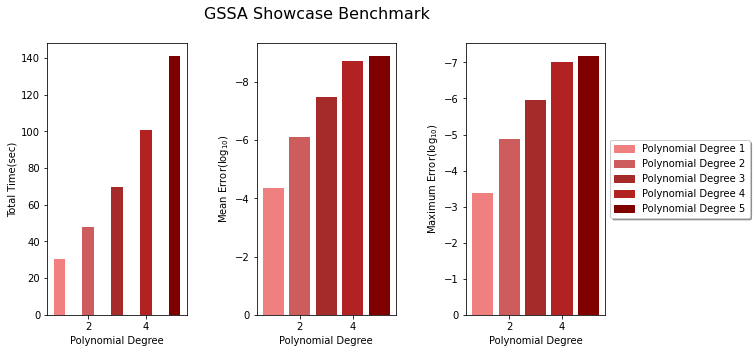

In [5]:
Figure2(showcase_result)

The results of the GSSA is remarkable. Not only does the increase of polynomial increase the accuracy, but it also attains an astonishing average of $10^{-9}$ in polynomial degree 4 and 5. Despite computational cost increases with higher polynomial degree due to the convergent prerequisite, GSSA has successfully ensured the numerical stability for all polynomial degrees. We will go more in depth regarding individual regression and intergration methods in the following sections, where we will dicuss how these methods help GSSA to overcome the undesirable traits from a generic simulation algorithm.

<div class="alert alert-block alert-success">
<b>Short conclusion:</b> These results further confirm that GSSA overcome the two main problems from the original PEA: (1) numerical instability and (2) low accuracy in higher polynomials.
</div>

# 4. Stability and Accuracy Enhancement <a id='chap4'></a>
---

In order to fully realise the potential of simulation method, both accuracy and numerical instability in higher polynomials need to be conquered simultaneously. In this section, we will first look at why normal OLS failed to provide accurate estimations then provide potential solutions to enhance both stability and accuracy. I also include a benchmark figure with the realisation of each methods in GSSA.

## 4.1 Ill-conditioned LS problems <a id='chap4.1'></a>
---

Instability issue are in general inavoidable for simulation methods, as higher polynomials stem from lower polynomial. We will use the frame work of representative agent model to identify this issue. We start by rewriting equation (9) into the following:

\begin{align*}
\psi(k_{t},a_{t};b) = \sum^{n}_{i=0}b_{i}\psi_{i}(k_{t},a_{t}) 
\end{align*}

Which combining with equation (13) implies the following equation:

\begin{align*}
y = Xb+\epsilon \tag{14}
\end{align*}

Notice that all parameters represent a vector, such that $y\equiv (y_{0},y_{1},...,y_{T-1})^{\top}\in \mathbb{R}^{T}$, $x\equiv [1^{T},x_{1},...,x_{n}]\in \mathbb{R}^{T\times(n+1)}$, and $\epsilon \equiv (\epsilon_{0},\epsilon_{1},...,\epsilon_{T-1})^{\top} \in \mathbb{R}^{T}$. We can therefore obtain the estimator $\hat b$ with OLS that minimise the error term:
\begin{align*}
\hat b = (X^{\top}X)^{-1}X^{\top}Y \tag{14}
\end{align*}

We will now define a measurement that measures the degree of ill conditioning of $X^{T}X$:
\begin{align*}
k(X^{\top}X)\equiv \frac{\lambda_{1}}{\lambda_{n}}
\end{align*}
$\lambda_{1}$ denotes the largest eigenvalue by decomposing $X^{\top}X$, while the $\lambda_{n}$ represents the smallest eigenvalue. If $k(X^{\top}X)$ is large, one can expect the value to be close to singular, which implies the $(X^{\top}X)$ in equation (15) is not invertible. There are two main reasons why the linear model is ill-conditioned: (1) Scaling problem and (2) Multicollinearity. I will use the examples from the authors to show how perturbation from these two reasons will impact the numerical stability of the coefficients:

- Scaling:
Assume $X = \begin{bmatrix} 1 & 0 \\ 0 & \phi \end{bmatrix}$, where $\phi$ (is not zero) and $k(X^{\top}X) = (\frac{1}{\phi})$. Suppose there are some perturbation that causes $y$ to be $y = (\epsilon_{1},\epsilon_{2})^{\top}$. The OLS solutions are:
\begin{align*}
\begin{cases}
\hat b_{1} = \epsilon_{1}\\
\hat b_{2} = \frac{\epsilon_{2}}{\phi}
\end{cases}
\end{align*}

- Multicollinearity:
Assume now $X = \begin{bmatrix} 1+\phi & 1 \\ 1 & 1+\phi \end{bmatrix}$ then $k(X^{\top}X) = (1+\frac{2}{\phi})^{2}$. If $y$ is expose to some error terms, such that $y = (\epsilon_{1},\epsilon_{2})^{T}$ then the solutions become:
\begin{align*}
\begin{cases}
\hat b_{1} = \frac{1}{\phi}\left[\frac{\epsilon_{1}(1+\phi)-\epsilon_{2}}{2+\phi}\right]\\
\hat b_{2} = \frac{1}{\phi}\left[\frac{\epsilon_{2}(1+\phi)-\epsilon_{1}}{2+\phi}\right]
\end{cases}
\end{align*}

We can observe that in both cases, the solutions are proportional to $\frac{1}{\phi}$ and is related with $k(X^{T}X)$. This means that both problems will magnify the impact of the perturbution. In the case of our simulation model, the magnifying property will accumulate through the iterations and results in erratic jumps in coefficients, not to mention some numerical errors such as rounding. This ultimately leads to the non-converging regression solutions, therefore it is essential for the GSSA model to employ methods that can tackle with scaling and multicollinearity.

## 4.2 Stability Enhancement <a id='chap4.2'></a>
---

GSSA employs least squared singular value decomposition (LS-SVD), least absolute deviation (LAD), and principal component method as the main regression methods. These methods combined with regularisation, not only produce accurate results by penalising large deviations, but are also capable of handling ill-conditioned data. This will therefore allow us to increase the stability. Moreover, different types of polynomial families will also affect the stability.

<div class="alert alert-block alert-success">
<b>Side note:</b> All regularised methods include the normalisation of the variables, and can be manually turn on in GSSA for OLS, LS-SVD, and LAD-PP. The normalisation aims to address the scaling problem described in section (4.1). This is done by: (1) Assuming both y and X have a mean of 0 and unit standard deviation. (2) Run the regression to get the solutions. (3) Restore the "real" solutions by using the sample mean and sample standard deviation. For more mathematic details please consult Judd et al.(2011)
</div>

### 4.2.1 Polynomial Families <a id='chap4.2.1'></a>
---

We will first look at the potential impact of different type of polynomial families. This is essential, as GSSA relys on a basis polynomial family to construct $X$ and also for parameterising the target policy function. Under the GSSA framework, two types of polynomial families are considered: (1) Ordinary polynomials (2) Hermite Polynomials. Ordinary polynomials $O_{m}(x)$ are consist of raising the power of the variable with corresponding degree. For instance, $O_{3}(x)$ denotes $x^{3}$. The problem with the oridnary polynomial family is the high correlation among high polynomials. This is further illustrated in the figure below as we can see it is impossible to tell the difference between different polynomials in range -1 to 1. Hermite polynomials on the other hand are constructed as the following:

\begin{align*}
\begin{cases}
H_{0}(x)=1\\
H_{1}(x)=X\\
H_{n}(x)=xH_{n}(x)-nH_{n-1}(x)
\end{cases}
\end{align*}

The biggest advantage of such construction is the polynomials are no longer highly correlated. However it is worth mentioning that Hermite polynomial family itself is not enough to rule out the entirity of the multicollinearity problem, as it only reduces the intensity of the correlation among polynomials. One example is the high correlation between $(k_{t}, a_{t})$ in the second polynomial: 


\begin{align*}
\begin{cases}
H_{2}(k_{t})= k_{t}^{2}-1\\
H_{2}(a_{t})= a_{t}^{2}-1
\end{cases}
\end{align*}

Therefore, in order to overcome multicollinearity, it is a unavoidable to utilise regression methods specific for solving multicollinear problems.

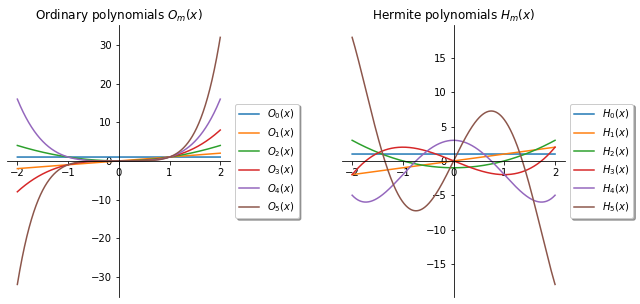

In [6]:
Figure3()

### 4.2.2 LS Approaches <a id='chap4.2.2'></a>
---

In this section, we will be looking at several LS methods that are capable of dealing with multicollinearity data. In addition, we will also expand the methods with regularisation methods to further increase the stability.

---
<br>
<strong>LS-SVD: </strong>

This method sidesteps the need of calculating $X^{\top}X$ explicity by decomposing $X$ such that $X=USV^{\top}$. The $U$ stands for unitary matrix, $S$ denotes non-negative real number rectancular diagonal matrix, while $V$ is another unitary matrix. $\hat b$ is now therefore $\hat b = VS^{-1}U^{\top}y$. Under the assumption that $X^{\top}X$ are ill-conditioned, it is possible that both $X$ and $S$ are well-conditioned, therefore the problem is solvable. 

<br>
<strong>RLS-Tikhonov: </strong>
<br>

Tikhonov regularisation rewrites the original $b \in arg_{min}\lVert y-Xb \rVert$ into $b \in arg_{min}\lVert y-Xb \rVert^{2}_{2}+\eta \lVert b \rVert^{2}_{2}$. The goal of this method, is to transform the original ill-conditioned problem into a simplier ill-conditioned problem. This mechanism is also classified as a shrinkage method as compared to its counterparts, Tikhonov shrinks the norm for the coefficients. The $\eta$ in the second term is the penalty parameter, where the larger the $\eta$ is, the greater the shrinkage. The estimator will therefore become $\hat b(\eta) = (X^{\intercal}X+\eta I_{n})^{-1}X^{\top}y$. One can immediately recognise that Tikhonov regularisation add the term $\eta I_{n}$ to the original $(X^{\top}X)$, this reduce the probability of $(X^{\top}X)$ of being singular, which in turn results in failure of calculation. Despite the advantage of tackling ill-conditioned problems, Judd et al. (2011) notify that the estimator $\hat b(\eta)$ can be biased with a large $\eta$. However, Hoerl and Kennard's findings show that it is possible to achieve a smaller mean square than the original OLS with the correct $\eta$. In Judd et al. (2011), they select the $\eta$ for the GSSA manually by iterating over different values of potential $\eta$.

<br>
<strong>RLS-TSVD: </strong>
<br>

Regularised LS using truncated SVD (RLS-TSVD) are a modified version of LS-SVD with ideas borrowed from principal component method(PCM). To see how it works, we will need to first consider how PCM tackle with multicollinearity. Consider the a linear transformation of the SVD's $X \in \mathbb{R}^{T \times n}$ such that $Z\equiv XV$. Both $Z$ and $V$ are the unitary matrices, and $z_{1},z_{2},..,z_{n}$ vectors are the principle components of the original $X$, with the following property:
$$
\begin{align}
z^{\top}_{i^{'}}z_{i} = 
\begin{cases}
    0 & \text{If $i^{'} = i$} \\
    s^{2}_{i} & \text{If $i^{'} \neq i$} \\
\end{cases}
\end{align}
$$

Where $s_{i}$ denotes the singular value, and each $z_{i}$ have the mean of zero and variance of $\frac{s_{i}^{2}}{T}$. Given that SVD method automatically orders the singular values from large to small, $z_{1}$ will have the largest singular values and $z_{n}$ will have a close to zero variance. If in partcular the $z_{n}$ is indeed zero, this means $x_{1},...,x_{n}$ will be linear dependent. This is where the truncation comes into play. By eliminating the elements from the $k$ to $n$, we can ensure that $x_{1},..,x_{k}$ are not ill-conditioned. The cost of this method is that we can only approximate the origin $Xb$ with only part of itself, where the disregards may contain useful information:
$$
\begin{align}
Xb=XVV^{-1}b \approx XV^{r}(V^{r})^{-1}b_{k}=Z^{r}\vartheta^{r} \tag{16} \\ 
\end{align}
$$
Equation (16) further transform the question into $\hat \vartheta^{r} \in arg_{min}\lVert y-Z^{r}\vartheta^{r} \rVert$. By using any LS or RAD methods, we can get our estimator $\hat \vartheta^{r}$. Afterwards, we can recover $\hat b(k)$ with $\hat b (k)= V^{r}\hat \vartheta^{r}$. Now, instead of using PCM to remove components that are collinear, we use the truncated SVD process directly, such that $X^{r} \equiv U^{r}S^{r}(V{r})^{\top}$. By using the theorm of Eckart and Young(1936), which states $X^{r}$ is the close rank approximation for $X$, we arrive to the equation $y=x^{r}b(r)+\varepsilon$. We can then rewrite the term $x^{r}b(r)$ to $U^{r}S^{r}\vartheta^{r}$ by substitution. This implies $y=U^{r}S^{r}\vartheta^{r}+\varepsilon$ and we can again use any methods to get our estimator $\hat \vartheta^{r}$ then use it to recover $\hat b(r)$. Our final estimator is describe as $\hat b(r)=V^{r}(S^{r})^{-1}(U^{r})^{\top}y$ where if $r=n$ then the answer will be the same as LS-SVD. RLS-TSVD biggest advantage, when compared to other LS methods, is that it is effectively a shrinkage method without any additional scalling or additions.

The benchmark is configured as the below settings:
<br>
<ul>
 <li>Simulation Length (Stage 1): 3000</li>
 <br>
 <li>Benchmarking Length (Stage 2): 10000</li>
 <br>
 <li>Regression Method: OLS & LS-SVD & RLS-Tikhonov (Larger penalty:-6, Smaller penalty:-4) & RLS-TSVD (Larger penalty:8, Smaller penalty:5)</li>
 <br>
 <li>Integration Method: Monte-Carlo </li>
 <br>
 <li>Polynomial Family: Hermite & Ordinary </li>
 </ul>

In [7]:
# For the sake of convenience, I have cache the results.
# One can of course change the True to False here, the code should have no problem running through.
result1, result2, result3 = Result_agent(cache=True)

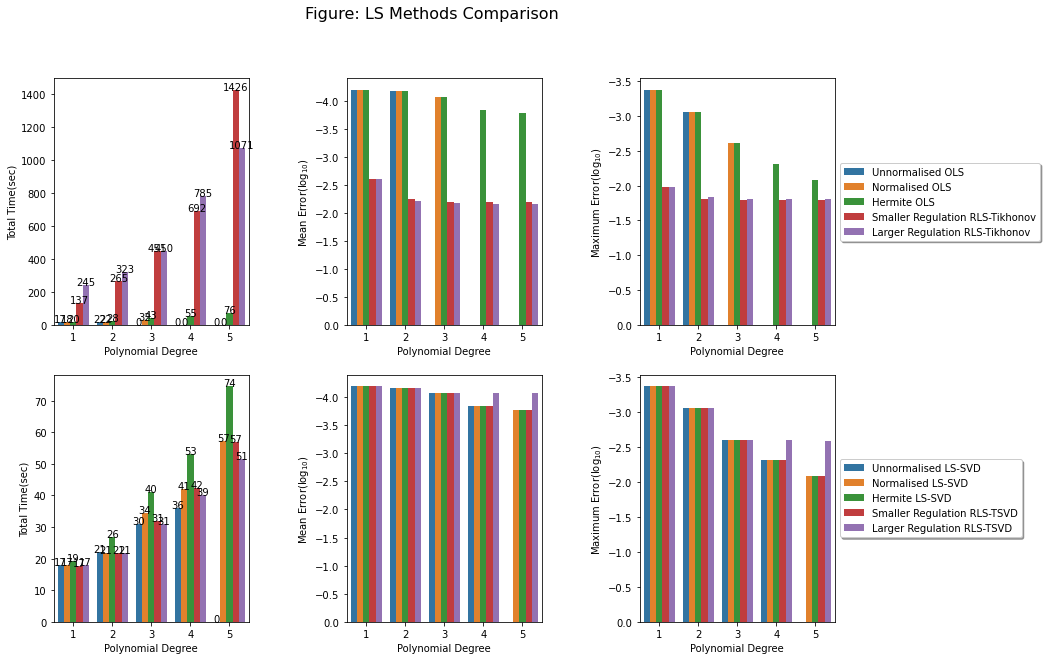

In [8]:
LS_Figure(result1, result2)

All regulation methods enable GSSA to obtain numercal stability in higher degree.  Normalisation deals with the scalling problem, but fails to deliever stable results for the 5th polynomial for LS-SVD and 4th polynomial for OLS. In this benchmark, we can tell the impact of switching polynomial family, as hermite allows OLS and LS-SVD to achieve stablility in the 5th polynomial degree. Tikhonov regulation method is more costly and slightly less precise than RLS-TSVD, this is because two methods work with different objects. Tikhonov still deals with the original ill-conditioned $X^{\top}X$, while RLS-TSVD only needs to work with a better conditioned $S$. Different regulation size does not interfer with the stability, but rather the accuracy.

<div class="alert alert-block alert-success">
<b>Side note:</b> The focus of this section is numerical stablility rather than the raw accuracy comparision, therefore I will not focus on accuracy comparision. To be more precise, the accuracy can be improved by switching the integration methods from Monte-Carlo to Gauss-Hermite, which we will analyse in section 4.3.
</div>

### 4.2.3 LAD Approaches <a id='chap4.2.3'></a>
---

LAD methods in general does not depend on the term $X^{T}X$ therefore are able to avoid the trap of multicollinearity. A basic LAD method solves the following optimising problem:
\begin{align*}
b \in argmin 1_{T}^{\intercal}\left| y-Xb \right| 
\end{align*}

Which can be transfer into a linear programming problem:
\begin{align*}
&min_{g,b} 1_{T}^{\intercal}g \tag{17}\\ 
&s.t. \quad -g 	\leq y-Xb \leq g 

\end{align*}

LAD methods in general are robust against outliers, when comparing to the LS counterparts. This is mainly because LAD does not square the errors for minimisation. Moreover, LAD is flexible and less computational expensive for additional linear restrictions. Nevertheless, LAD also possess two disadvantages, namely the solutions from LAD may not be continuous and LAD are more computational expensive than LS (as LAD needs to solve a linear programming problem with $n+T$ unknowns). In this section, we will be dicussing a particular branch of LAD, namely the LAD primal problem (LAD-PP) purposed by Charnes et al.(1955).

----

<br>
<strong>LAD-PP:</strong>
<br>
The primal problem changes the original $y-Xb$ into a canonical linear programming form. To see how it works, we start by rewriting the equation (13) as follows:
\begin{align*}
y_{t}-\sum^{n}_{i=0}b_{i}x_{ti}=v^{+}_{t}-v^{-}_{t}
\end{align*}

The $t$ represent the $t$ element of the given $i$th vector. The two nonnegative variables, $v^{+}_{t}$ and $v^{-}_{t}$ represent the magnitude above and below the fitting line of $X\hat b$ respectively. We can now follow the similar procedure as equation (17) to transfer this into a linear programming problem:
\begin{align*}
v^{+},v^{-},b \in &argmin 1^{\top}_{T}v^{+}+1^{\top}_{T}v^{-}\\
&s.t. \quad v^{+}-v^{-}+Xb=y\\
&v^{+}\geq 0, \quad v^{-}\geq 0 

\end{align*}
The main advantage of LAD-PP compared to the original LAD, is that the inequality of the variables have been reduced only to a lower bound of bigger than 0. This can improve the efficiency of LAD and implies less computational cost.

<br>
<strong>RLAD-PP:</strong>
<br>

Regularised LAD-PP is the modification of the previous LAD-PP, by adding the Tikhonov regularisation. This transforms the equation from $b \in arg_{min}\lVert y-Xb \rVert$ into $b \in arg_{min}1^{\top}_{T} \lVert  y-Xb \rVert_{1}+\eta \lVert b \rVert_{1}$. Recall that the in primal problem, we decompose the first part into $v^{+}_{t}$ and $v^{-}_{t}$. Similarily, the penalty part can be described two nonnegative variables, which we will denote as $\varphi^{+}$ and $\varphi^{-}$. Therefore we arrive in the follow equation:
\begin{align*}
v^{+},v^{-},\varphi^{+}, \varphi^{-} \in &argmin 1^{\top}_{T}v^{+}+1^{\top}_{T}v^{-}+\eta 1^{\top}_{n}\varphi^{+} + \eta 1^{\top}_{n}\varphi^{-}\\
&s.t. \quad v^{+}-v^{-}+X(\varphi^{+}-\varphi^{-})=y\\
&v^{+}\geq 0, \quad v^{-}\geq 0 \\
&\varphi^{+}\geq 0, \quad \varphi^{-}\geq 0 

\end{align*}

<div class="alert alert-block alert-success">
<b>Side note:</b> In Judd et al. (2011) they also mention another type of LAD, namely the Dual Problem of the linear programming problem. However, I fail to implement this mechanism in GSSA due to computational reasons. A more detailed explanation can be found in the file "GSSA_1_agent.py" under the function "Num_Stab_Approx"
</div>

The benchmark is configured as the below settings:
<br>
<ul>
 <li>Simulation Length (Stage 1): 3000</li>
 <br>
 <li>Benchmarking Length (Stage 2): 10000</li>
 <br>
 <li>Regression Method: LAD-PP & RLAD-PP (Larger penalty:-2, Smaller penalty:-4) </li>
 <br>
 <li>Integration Method: Monte-Carlo </li>
 <br>
  <li>Polynomial Family: Hermite & Ordinary </li>
 </ul>

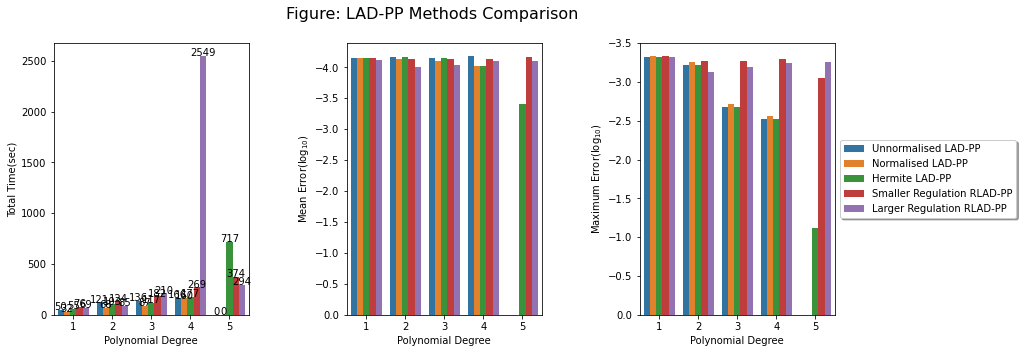

In [9]:
LAD_figure(result3)

Similar to the LS methods, all regulation methods are able to obtain numerical stability in higher polynomial degrees. The penalty also does not interfer with the stability but rather the accuracy. On average, smaller regulations in RLAD-PP outperforms the larger regulations, despite it is not clearly visable. The reason may be because large regulation lead to coefficients that are biased therefore reduce the accuracy. Compared to the LS counterparts, LAD-PP methods are indeed more expensive. Hermite polynomials help LAD-PP to obtain numerical stability in higher degree of polynomial, while normalisation fails to ensure the stability in the 5th polynomial degree.

<div class="alert alert-block alert-success">
<b>Short conclusion:</b> In order to increase the stability of simulation methods we can either:
<ol>
 <li>Switch polynomial family</li>
 <li>Normalise the data</li>
 <li>Use regression methods that are capable of handling ill-conditioned data</li>
</ol>
Overall our findings suggest method (3) is the most effective, which even comes with a small boost of accuarcy
</div>

## 4.3 Accuracy Enhancement <a id='chap4.3'></a>
---

Judd et al.(2011) emphasis the method of integration plays a deterministic role on the accuracy of simulation models. Following their discussion, we will be looking at three different types of methods: Monte-Carlo, Gauss-Hermite quadrature, and finally monomial. Accompanying the theoretical reasoning, I include the implementations of different integration methods under the GSSA framework. The results support the claim of Judd et al.(2011).

---

<br>
<strong>Monte-Carlo:</strong>
<br>

A $N$-node Monte-Carlo intergration draws $N$ numbers of shock $\{\epsilon_{t+1,j}\}_{j=1,...,N}$ and compute $y_{t}$ in equation (12). Notice that the shock $\epsilon_{t+1,j}$ differs from $\epsilon_{t+1}$, as the latter one describe the shock from the simulations (iterations). The error from integration can be expressed with $\varepsilon^{I}_{t}=y_{t}-E(\cdot)$ where the $E(\cdot)$ denotes the conditional expectation from equation (11). By substitution, we can express equation (14) as $\hat b = b + [(X)^{\top}(X)]^{-1}(X)^{\top}\varepsilon^{I}$, where $\varepsilon^{I}$ denotes $\{\varepsilon^{I}_{t}\}_{t=1,..,T}$. Assume $\{\varepsilon^{I}_{t}\}_{t=1,..,T}  \sim \mathcal{N}(0,\,\sigma^{2})$ are i.i.d., we finally arrive to the asymptotic distribution of the OLS estimator $\sqrt{TN}(\hat b - b) \sim \mathcal{N}(0,\,[X^{\top}X]^{-1}\sigma^{2})$. 

We draw a short conclusion from the distribution we just derived: In order to lower the error term, one must either raise the simulation length $T$ or the number of shocks $N$. Combined with the fact that Monte-Carlo has a slow convergence rate $\sqrt T$ (see Caflisch (1998)), it is impractical to achieve high accuracy with simulations method. For example, if we want to calculate a unit-free integration error defined as $\frac{y_{t}-E(\cdot)}{E(\cdot)}$, we will need a simulation length of 1,000,000 in order to lower the error to an average of $10^{-5}. 

<br>
<strong>Gauss-Hermite: </strong>
<br>

Instead of drawing $N$ shocks, $N$-node Gauss hermite quadrature integration ($Q(n)$) approximates equation (12) from assigning $\epsilon_{t+1,j}$ with $N$ deterministic integration nodes $\nu$ and weights $\omega$:
$$
\begin{align*}
\int_{\mathbb{R^{N}}}G(\epsilon)\omega(\epsilon)d\epsilon  \approx \pi^{-N/2} \sum^{J_1}_{j1=1}...\sum^{J_N}_{jN=1}\omega^{1}_{j1}...\omega^{N}_{jN}G(\sqrt2 \Omega (\nu^{1}_{j},...,\nu^{N}_{jN})^{\top}) \tag{18}
\end{align*}
$$
Where $G(\cdot)$ in this case is our approximation function. For example, $\epsilon_{t+1,1}=0$ with a weight $\omega_{t+1,1}$ of 0 under $Q(1)$, while $\epsilon_{t+1,1}=-\sigma$ with a weight $\omega_{t+1,1}$ of $\frac{1}{2}$ under $Q(2)$. The complete mathematics derivation and the table of all weights and nodes for $Q(n)$ can be found at Judd (1998, p.261). The biggest advantage of $Q(n)$ is the accuracy it provides. Assuming the target function for approximation is continuous, $Q(n)$ decrease the error rapidly with more integration nodes added. The integration formula also relies on the degree of polynomials, which means it is possible to address the issue of higher polynomials do not yield better accuracy in the simulation methods with $Q(n)$. The drawback from this methods lies in the number of node constructions, in particular, $Q(n)$ is extremely costly for approximating over multidimension integrals. From equation (17) we can see that the total number of nodes are $J_1 \cdot J_2,...,J_N$. Assuming we want to estimate a multidimension case with $k$ agents, we will need to construct $(J_1 \cdot J_2,...,J_N)^{k}$ number of nodes.

<br>
<strong>Monomial: </strong>
<br>

Monomial integration aims to deal with the exponential node problem from the $Q(n)$. The entire mathematic derivation of constructing a monomial formula to deal with multicollinearity is beyond the scope of this notebook. However, one can find a detailed explanation in the appendix of Judd et al. (2011) where they showcase the entire procedures. The advantage of Monomial integration rule is that it does not rely on the product of nodes, but rather the summation. This means that the cost only grows polynomially and not exponentially.

The benchmark is configured as the below setting:
<br>
<ul>
 <li>Simulation Length (Stage 1): 3000</li>
 <br>
 <li>Benchmarking Length (Stage 2): 10000</li>
 <br>
 <li>Regression Method: RLS-TSVD with penalty -7 </li>
 <br>
 <li>Integration Method: Monte-Carlo & 1-Node Gauss-Hermite & 10-Node Gauss-Hermite </li>
 <br>
 <li>Polynomial Family: Ordinary </li>
 </ul>


<div class="alert alert-block alert-success">
<b>Side note:</b> Similar to Judd et al. 2011, I only include Monomial integration method in the multicountry model. Therefore, it is not included in the 1-agent benchmark below.
</div>

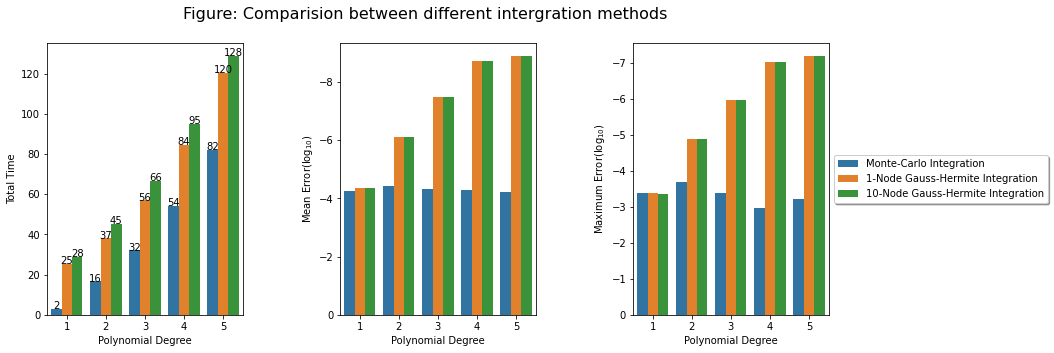

In [10]:
Figure4()

The benchmarking results match our theoretical expectations. The Monte-Carlo have a overall lower cost, but fail to deliever good accuracy in higher polynomial degrees. Under Monte-Carlo, higher polynomial degree does not deliever better accuracy. In contrary, both 1-Node Gauss-Hermite and 10-Node Gauss Hermite ensure the increase in accuracy for higher polynomials. We also observe that changing the nodes does not results in changes in error term, which matches the results from Judd et al. (2011). All things considered, this benchmark also highlights that the conventional usage of Monte-Carlo in simulation methods, is the key reason why simulation methods are not able to achieve high accuracy. 

## 5. Countries Implementation<a id='chap5'></a>
---

We will now expand our representative agent problem into a multicountry high-dimensional problem. Assume the economy is made of $N \in \mathbb N^{+}$ countries. Each country $h \in {1,...,N}$ is represented by one destinctive consumer. Beyond the world, there is a social planner whose objective is to maximise all of the destinctive consumer in different countries. The objective optimisation problem can be written as:


\begin{align*}
& max_{\{c^{h}_t,k^{h}_t+1\}_{t=0,...,\infty}}E_{0}  \sum^{N}_{h=1}\lambda^{h} \left[ \sum^{\infty}_{t=0}\beta^{t}u^{h}(c^{h}_t) \right] \tag{19}\\
s.t. &\qquad \sum^{N}_{h=1}c^{h}_t+\sum^{N}_{h=1}k^{h}_{t+1}= \sum^{N}_{h=1}k^{h}_t(1-\delta)+ \sum^{N}_{h=1}a^{h}_t A f^{h}(k^{h}_t), \tag{20} \\

& \qquad \ln a^{h}_{t+1} =\rho \ln a^{h}_t+\epsilon^{h}_{t+1} \tag{21} \\


\end{align*}

The $u^{h}(\cdot)$ in equation (19) represents the $h$th country's utility function. Equation (20) further defines the aggregate resource constraint with $f^{h}(\cdot)$ denoting country production function, while equation (21) denotes individual country's productivity level. Similar to the setting of representative agent, $\{K^{h}_0,a^{h}_0\}^{h=1,...,N}$ are information that we already know. $c^{h}_t$ represents the $h$th country's consumption level during time $t$, while $k^{h}_t$, and $\lambda^{h}_t$ stands for capital and welfare weight. The $\beta$ again denotes discount factor, while $\delta$ is the depreciation rate. $A$ is the normalising constant for production, and $\rho$ stands for autocorrelation coefficient. The productivity shock in this framework is a multivariate normal distribution $\mathcal{N}(0_N,\,\Sigma)$, where $0_N$ denotes a vector of zeros with the length $N$ and $\Sigma \in \mathbb R^{N\times N}$ denotes the covariance matrix. In the setting of Judd et al.(2011), they assume the shock for each country during $t+1$ can be broken into two parts: (1) Country specific error $\iota^{h}_{t+1} \sim \mathcal{N}(0,\,\Sigma)$ (2) World specific error $\iota^{h}_{t+1} \sim \mathcal{N}(0,\,\Sigma)$. This can be express as the the equation $\epsilon^{h}_{t+1}=\iota^{h}_{t+1}+\iota_{t+1}$. Therefore $\Sigma \equiv   \begin{Bmatrix} 
      2\sigma^{2} & \ldots  & \sigma^{2}  \\ 
      \vdots & \ddots & \vdots  \\ 
      \sigma^{2} & \ldots & 2\sigma^{2}
   \end{Bmatrix}$. 
   
Equation (19) to (21) must also satisfy Euler's equation:

\begin{align*}
k^{h}_{t+1} = E_t \Bigg\{\beta\frac{u^{'}(c_{t+1})}{u^{'}_(c_t)} \left[ 1-\delta+a^{h}_t+1Af^{'}(k^{h}_t+1) \right]k^{h}_{t+1}  \Bigg\}

\end{align*}

Which we can combine it with the some flexible function form that implies a choice of policy function to approximate for country $h$'s capital policy function:

\begin{align*}
k^{h}_{t+1} = K^{h}(\{k_t^{h}, a_t^{h}\}^{h=1,..,N})\approx \psi^{h}(\{k_t^{h}, a_t^{h}\}^{h=1,..,N};b^{h}), h = 1,...,N

\end{align*}


The rest of the calculations follow the stage 1 of GSSA.

We will now kickstart our benchmarking with only 1 to 2 countries. One can imagine the 1 country case is similar to the previous representative agent problem. All polynomials are calculated to showcase the difference from computational cost, mean error, and maximum error.

The benchmark is configured as the below setting:
<br>
<ul>
<li>Number of countries: 1 & 2 </li>
 <br>
 <li>Simulation Length (Stage 1): 2000</li>
 <br>
 <li>Benchmarking Length (Stage 2): 10200</li>
 <br>
 <li>Regression Method: RLS-TSVD with penalty -7 </li>
 <br>
 <li>Integration Method: Monomial </li>
 <br>
 <li>Polynomial Family: Ordinary </li>
 </ul>

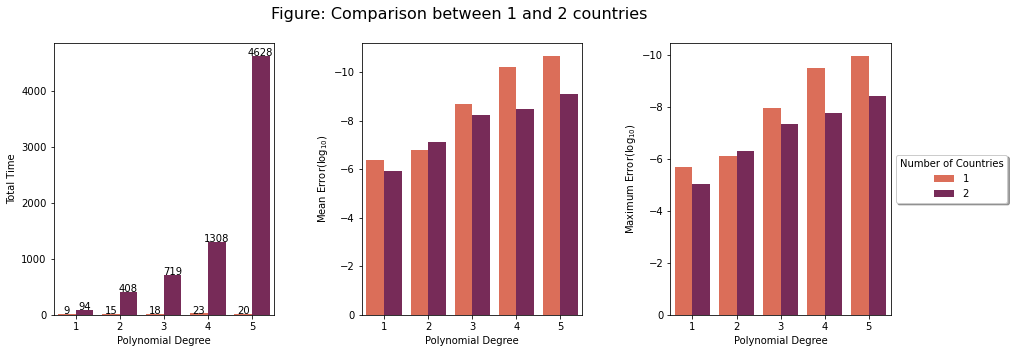

In [11]:
country_Figure1()

We can see the computational cost increase dramatically with a 1000% increase in the first polynomial and a staggering 2310% increase for the fifth polynomial. Througout the mean and maximum error, both cases have an increase accuracy in higher polynomials. The 1-country accuracy compared to the 2-country counterpart have higher accuracy in general. Despite of this, the mean error and the maximum error from both sides are astonishing. In the 1-country case, it obtains mean error of $10^{-10}$ and maximum error of $10^{-9}$, while in the 2-county case it obtains mean error with $10^{-9}$ and maximum error of $10^{-8}$.

We will now push the GSSA even further, by including 10 to 100 countries to showcase that GSSA indeed is capable of tackling large-scale economics problem. Notice here we will only be looking at the first polynomial due to the computational expense, which is because polynomials of higher degree have too many coefficients to identify for the simulation length $T$.

The benchmark is configured as the below setting:
<br>
<ul>
<li>Number of countries: 10 ~ 100 </li>
 <br>
 <li>Simulation Length (Stage 1): 2000</li>
 <br>
 <li>Benchmarking Length (Stage 2): 10200</li>
 <br>
 <li>Regression Method: RLS-TSVD with penalty -7 </li>
 <br>
 <li>Integration Method: Monomial </li>
 <br>
 <li>Polynomial Family: Ordinary </li>
 </ul>

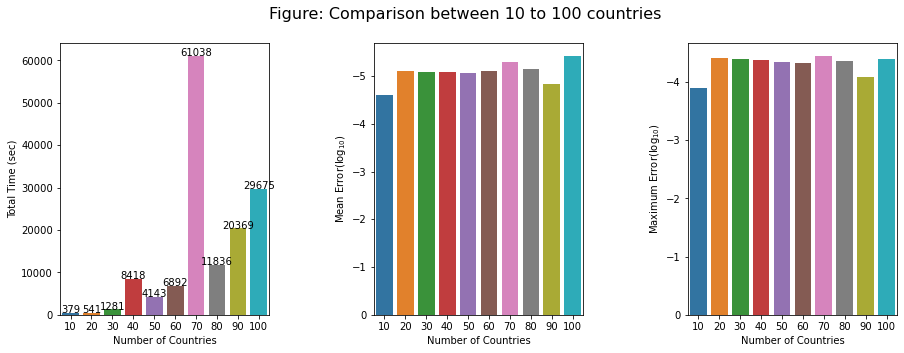

In [12]:
country_Figure2()

Computational cost for larger-scale economy is unsurprisingly costly compared to smaller-scale economy. There do exists an irregular jump in cost for the 70-country case but also in the 40-country case. In terms of accuracy, it is not as staggering as the previous benchmark but overall achieve great consistency. The drop of accuracy is however expected, as the number of countries increases, so does the number of coefficients. To increase the accuracy one can of course increase the simulation length even further, but it comes with a high cost. Overall, both the mean and the maximum errors still give excellent results, with an average of $10^{-5}$ and $10^{-4}$ respectively.

## 6. Conclusion <a id='chap6'></a>
---

In this notebook, we introduce the GSSA developed by Judd et al.(2011) under the python setting. GSSA 

More importantly, GSSA fully realised the potentials for simulation stochastic methods by dealing with both numerically instability and poor accuracy of higher polynomials.


The GSSA can also be extended to the financial analysis. Dupacova et al. (2006) purpose models 

### Reference <a id='ref'></a>
---

Caflisch, R. E. (1998). Monte carlo and quasi-monte carlo methods. Acta numerica, 1998, 1-49.

Christiano, L. J., & Fisher, J. D. (2000). Algorithms for solving dynamic models with occasionally binding constraints. Journal of Economic Dynamics and Control, 24(8), 1179-1232.

Maliar, L., & Maliar, S. (2003). Parameterized Expectations Algorithm and the Moving Bounds. Journal of Business & Economic Statistics, 21(1), 88-92.

Dupacova, J., Hurt, J., & Stepan, J. (2006). Stochastic modeling in economics and finance (Vol. 75). Springer Science & Business Media.

Den Haan, W. J., & Marcet, A. (1990). Solving the stochastic growth model by parameterizing expectations. Journal of Business & Economic Statistics, 8(1), 31-34.

Judd, K., Maliar, L., & Maliar, S. (2011). One-node quadrature beats Monte Carlo: a generalized stochastic simulation algorithm (No. w16708). National Bureau of Economic Research.

Judd, K. L., & Judd, K. L. (1998). Numerical methods in economics. MIT press.

